# Geospatial ML - Feature Augmentation - Part II

Part II in the series 

### Orignal Repo

is [here](https://github.com/Solve-Geosolutions/transform_2022)

### Original Data License

All data presented in this tutorial were derived from open data sets made available through [Mineral Resources Tasmania](https://www.mrt.tas.gov.au/) and [Geoscience Australia](https://www.ga.gov.au/).

**LICENSE CONDITIONS**

By exporting this data you accept and comply with the terms and conditions set out below:

[Creative Commons Attribution 3.0 Australia](https://creativecommons.org/licenses/by/3.0/au/)

<img src="assets/creative_commons_logo.png" />

# Why This Mining Geology Example?

This is a great example of how we need to account for [spatial autocorrelation](https://www.paulamoraga.com/book-spatial/spatial-autocorrelation.html#) (another reference [here](https://mgimond.github.io/Spatial/spatial-autocorrelation.html)) for machine learning projects. Rocks generally (but not always!) are not time dependent. I would not necessairly use the same methods for time dependent weather/climate datasets. 

You might need to add these two packages to your enviroment:

In [1]:
!pip install rasterio

In [2]:
!pip install imblearn

In [3]:
!pip install scikit-image

In [4]:
# Import key packages
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler

from skimage import feature
from scipy.ndimage import binary_dilation

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

print('XGboost version', xgb.__version__ )

XGboost version 2.0.3


In [6]:
# set some plotting parameters 
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

## Speed running through data loading

Any code that was ran in notebook 1 will be condensed and shortned. 

In [7]:
data_dir = 'geodata/'

# set path to minoccs
point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')

# make a list of rasters in the data directory
geotiffs = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x]
point_fn, geotiffs

('geodata/sn_w_minoccs.gpkg',
 ['geodata/tasmag_TMI.tif',
  'geodata/tasrad_K_pct.tif',
  'geodata/tasrad_U_ppm.tif',
  'geodata/tasgrav_IR_1VD.tif',
  'geodata/tasmag_TMI_1VD.tif',
  'geodata/tasrad_Th_ppm.tif',
  'geodata/tasgrav_IR.tif'])

In [8]:
# read in the point file
df = gpd.read_file(point_fn)

### Reading in GeoTiffs

In [9]:
# read geotiffs
data, names = [], []  # Lists to store data and corresponding file names
for fn in geotiffs:  # Loop through each GeoTIFF file
    with rasterio.open(fn, 'r') as src:  # Open GeoTIFF file for reading
        # read spatial information
        transform = src.transform  # Get affine transformation matrix
        region = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])  # Get bounding box coordinates (left, bottom, right, top)
        # read band 1 data
        d = src.read(1)  # Read data from the first band
        nodata_mask = d == src.nodata  # Create a mask for NoData values
        d[nodata_mask] = np.nan  # Replace NoData values with NaN
        # append data to lists
        data.append(d)  # Append data to the list
        names.append(os.path.basename(fn).replace('.tif',''))  # Append file name to the list (without extension)

# stack list into 3D numpy array
data = np.stack(data)  # Stack the list of arrays into a 3D numpy array
data.shape, names  # Return the shape of the data array and the list of file names

((7, 2633, 1876),
 ['tasmag_TMI',
  'tasrad_K_pct',
  'tasrad_U_ppm',
  'tasgrav_IR_1VD',
  'tasmag_TMI_1VD',
  'tasrad_Th_ppm',
  'tasgrav_IR'])

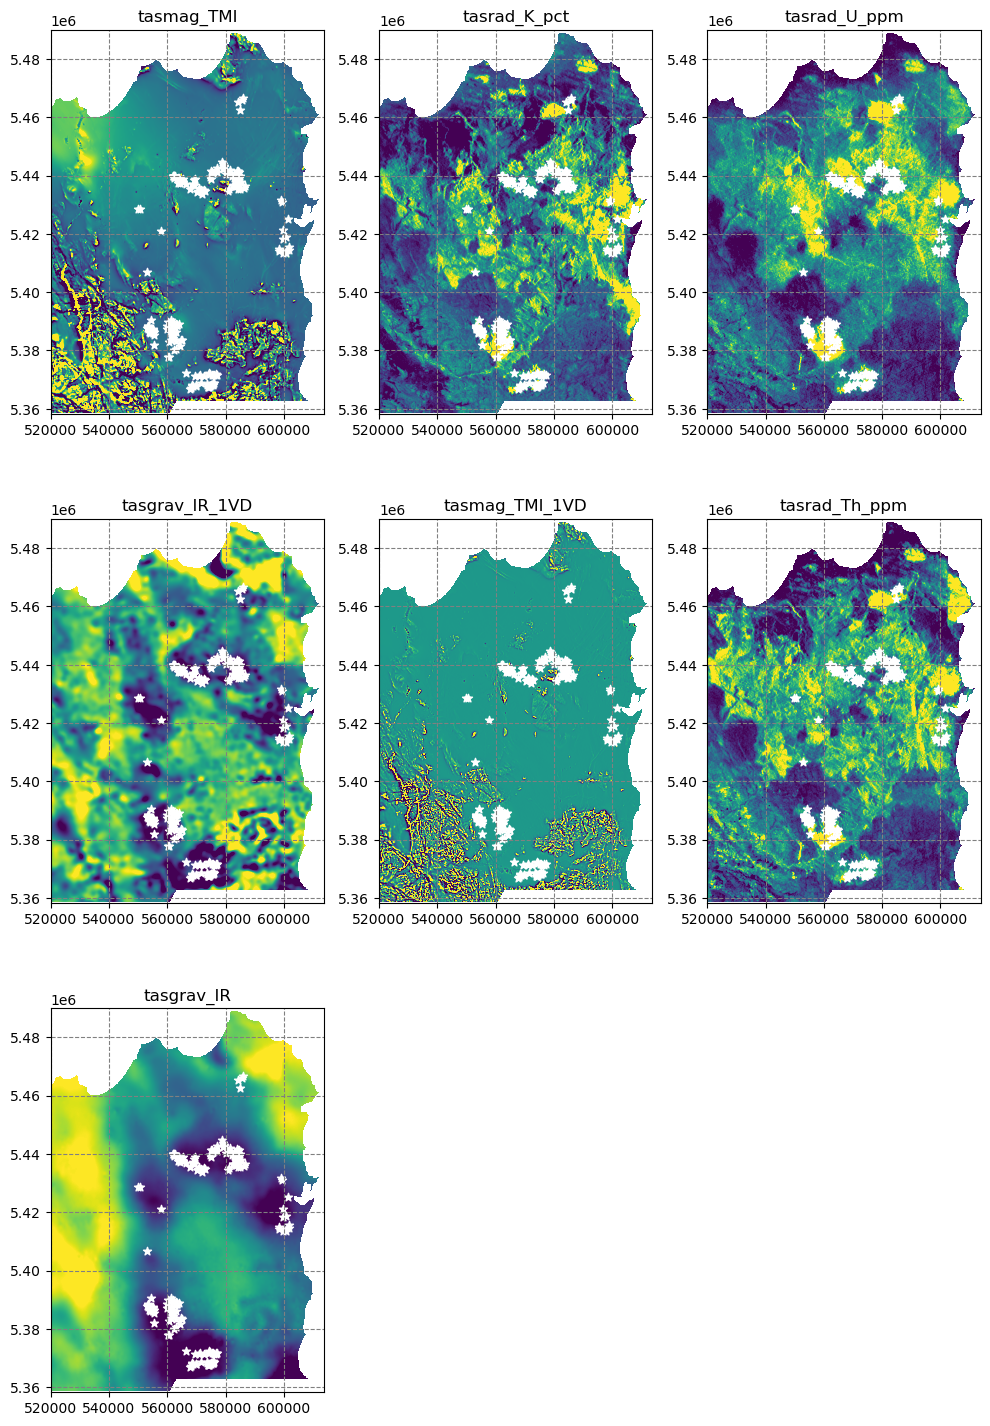

In [10]:
# plot the data
fig, axes = plt.subplots(3,3,figsize=(12,18))
for i, ax in enumerate(axes.flatten()):
    if i < data.shape[0]:
        ax.imshow(data[i], vmin=np.nanpercentile(data[i], 5), vmax=np.nanpercentile(data[i], 95), extent=region)
        ax.set(title=names[i])
        df.plot(ax=ax, marker='*', facecolor='w')
    else:
        ax.axis('off')
plt.show()

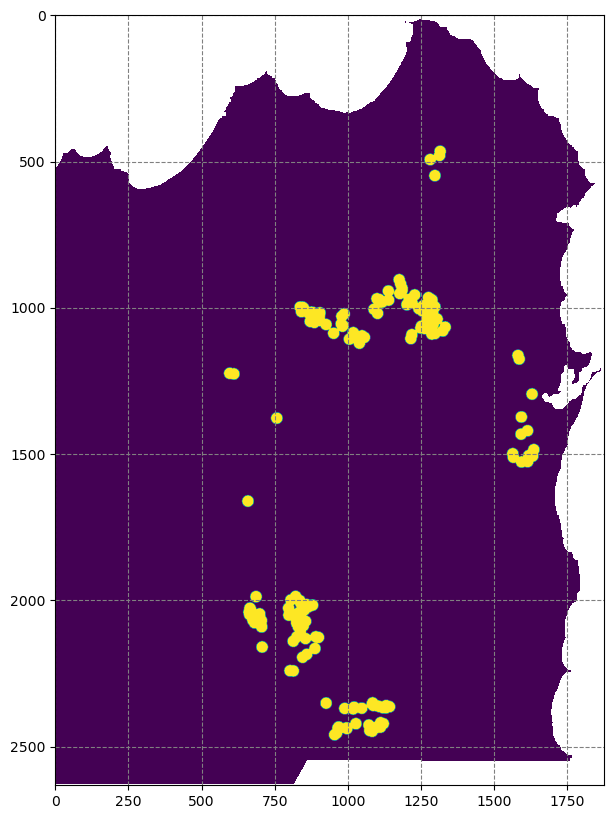

In [11]:
# rasterize the point
buffer = 1000

geometry_generator = ((geom, 1) for geom in df.buffer(buffer).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
labels[nodata_mask] = np.nan

plt.imshow(labels)

## Feature Engineering

Feature engineering is the process of transforming raw data into meaningful input variables, or features, that can be used by machine learning models to improve their performance. It involves creating new features, selecting the most relevant ones, and transforming existing features to better represent the underlying patterns in the data. Effective feature engineering requires a deep understanding of both the data and the problem domain, as it often includes tasks like encoding categorical variables, normalizing data, handling missing values, and even creating interaction terms between features. By refining the inputs, feature engineering enables models to capture complex relationships and patterns, ultimately leading to more accurate predictions. This process is dataset and ML model dependant. 

In this notebook, we will focus on the creation of new features as part of our feature engineering process. This involves generating new variables from the existing data that might better capture the underlying relationships. By focusing on this aspect of feature engineering, we aim to enhance the model's ability to learn from the data, leading to potentially better performance in our machine learning tasks (we will test this!).

When working with feature engineering, one concern is that adding too many features, especially those that are irrelevant or noisy, can lead to overfitting, where the model performs well on the training data but poorly on unseen data. However, using models like Random Forests can help mitigate this downside. Random Forests, being an ensemble method, build multiple decision trees on different subsets of the data and features. Each tree in the forest is trained on a random subset of features, which reduces the likelihood that any single noisy or irrelevant feature will dominate the model. Additionally, Random Forests have built-in feature importance metrics, allowing us to identify and prioritize the most relevant features while ignoring the less important ones. This robustness makes Random Forests particularly well-suited for working with a large number of features, including those generated during feature engineering, without significantly increasing the risk of overfitting.

### Generating addtional Filters

Let's make some addtional filters. These filters will 

In [12]:
def generate_broad_filter(size):
    """
    Generates a broad horizontal and vertical filter of a specified size.

    Parameters:
    -----------
    size : int
        The size of the filter. Must be an odd number.
    """
    assert size % 2 == 1, "Filter size must be an odd number."
    
    # Generate the first row pattern
    middle = size // 2
    first_row = np.arange(-middle, middle + 1)
    
    # Create the horizontal filter by repeating the first row
    horizontal_filter = np.tile(first_row, (size, 1))
    
    # Create the vertical filter by transposing the horizontal filter
    vertical_filter = horizontal_filter.T
    
    return horizontal_filter, vertical_filter

In [13]:
def convolve_all_3d_with_filter_and_clip(image, filter_size=3, clip=False, clip_percentiles=(20, 80)):
    """
    Convolves a 3D image with broad filters and optionally clips the output.

    Parameters:
    -----------
    image : np.ndarray
        The 3D input image array.
    filter_size : int, optional
        Size of the convolution filters (default is 3). Must be an odd number.
    clip : bool, optional
        Whether to clip the output based on percentiles (default is False).
    clip_percentiles : tuple of two floats, optional
        Percentiles for clipping the output (default is (20, 80)).

    Returns:
    --------
    combined_array : np.ndarray
        A 3D array with the vertical, horizontal, and combined convolved images stacked along the last axis.

    Example:
    --------
    >>> convolved_result = convolve_all_3d_with_filter_and_clip(image, filter_size=5, clip=True)
    """
    # Generate convolution kernels
    horizontal_kernel, vertical_kernel = generate_broad_filter(filter_size)
    
    # Replace NaNs with the median value
    image_no_nan = np.where(np.isnan(image), np.nanmedian(image), image)
    
    # Perform convolutions
    horizontal_convolved = convolve(image_no_nan, horizontal_kernel, mode='same')
    vertical_convolved = convolve(image_no_nan, vertical_kernel, mode='same')
    
    # Combine convolved results and apply NaN mask
    combined_convolved = np.sqrt(horizontal_convolved**2 + vertical_convolved**2)
    nan_mask = np.isnan(image)
    combined_convolved[nan_mask] = np.nan
    
    # Clip output if specified
    if clip:
        lower, upper = np.percentile(combined_convolved[~nan_mask], clip_percentiles)
        combined_convolved = np.clip(combined_convolved, lower, upper)
    
    # Stack convolved results into a single 3D array
    combined_array = np.stack((vertical_convolved, horizontal_convolved, combined_convolved), axis=-1)
    
    return combined_array

In [14]:
def canny_edge_detection_multi_sigma(image, sigmas=[1.0], buffer=1):
    """
    Perform Canny edge detection on a 2D image with multiple sigma values,
    apply a buffer to widen the edges, and convert the result to 0.0 and 1.0 
    while retaining the NaN mask.

    Parameters:
    - image: 2D numpy array
        The input image for edge detection.
    - sigmas: list of float
        A list of standard deviations of the Gaussian filter used in Canny edge detection.
    - buffer: int, optional
        The number of pixels to buffer (widen) the detected edges.

    Returns:
    - edges_nd: n-dimensional numpy array
        An n-dimensional array containing the widened edge detection results for each sigma
        as 0.0 and 1.0, with NaNs retained.
    """
    if image.ndim != 2:
        raise ValueError("The input image must be a 2-dimensional array.")
    
    # Calculate the median of the non-NaN elements
    median_value = np.nanmedian(image)
    
    # Replace NaNs with the median value
    image_no_nan = np.where(np.isnan(image), median_value, image)
    
    # Initialize a list to store edge detection results for each sigma
    edges_list = []
    
    # Loop over each sigma and perform edge detection
    for sigma in sigmas:
        # Perform Canny edge detection
        edges = feature.canny(image_no_nan, sigma=sigma)
        
        # Apply buffer (dilation) to widen the edges
        if buffer > 0:
            for _ in range(buffer):
                edges = binary_dilation(edges)
        
        # Convert the True/False values to 0.0 and 1.0 (as float)
        edges_float = edges.astype(float)
        
        # Create a mask to identify NaN positions in the original image
        nan_mask = np.isnan(image)
        
        # Apply the NaN mask to the result
        edges_float[nan_mask] = np.nan
        
        # Append the result to the list
        edges_list.append(edges_float)
    
    # Stack the results along a new axis to create an n-dimensional array
    edges_nd = np.stack(edges_list, axis=-1)
    
    return edges_nd

## Running The functions

In [15]:
d = convolve_all_3d_with_filter_and_clip(data[6])

In [16]:
w = canny_edge_detection_multi_sigma(data[6], sigmas=[1,3,5,10, 50, 100], buffer=3)

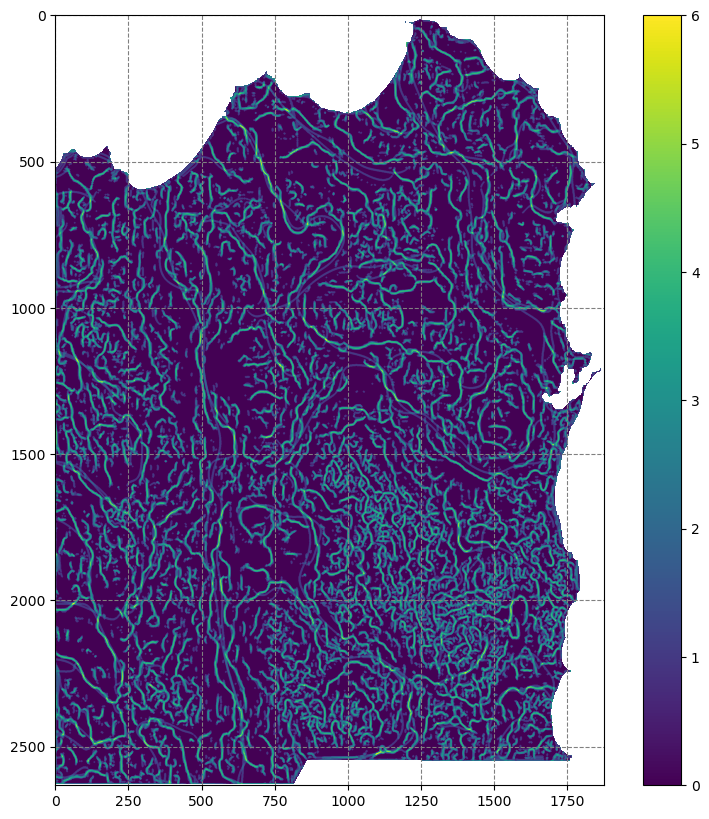

In [17]:
plt.imshow(np.sum(w, axis=2))
plt.colorbar()

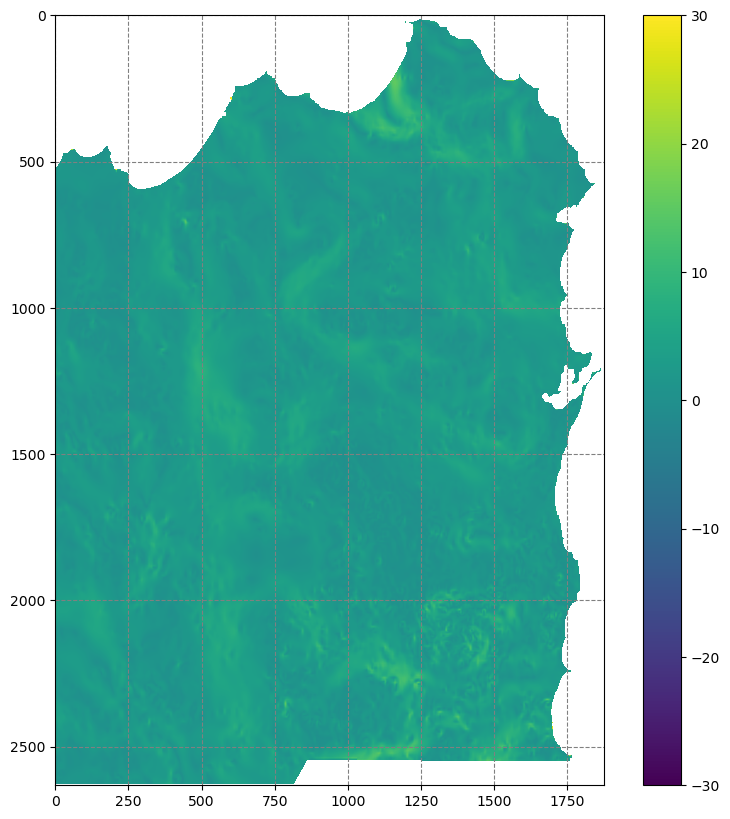

In [18]:
plt.imshow(d[:,:,2], vmin=-30, vmax=30)
plt.colorbar()

In [19]:
# Check if the first two dimensions match
if w.shape[0:2] == d.shape[0:2]:
    print("The first two dimensions of both arrays match.")
    merged_array = np.concatenate((w, d), axis=2)
else:
    print("The first two dimensions of the arrays do not match.")

The first two dimensions of both arrays match.


In [20]:
array = merged_array.transpose(2,0,1)
array.shape

(9, 2633, 1876)

In [21]:
data.shape

(7, 2633, 1876)

In [22]:
new_dataset = np.concatenate((array, data), axis=0)
new_dataset.shape

(16, 2633, 1876)

In [23]:
# Check dimensions
if np.shape(labels.flatten())[0] != np.shape(data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T)[0]:
    raise ValueError("Labels and Data shapes (0th dimmension) do not match.")

X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
y_pix = labels.flatten()

# remove nans
X = X_pix[~np.isnan(y_pix)]
y = y_pix[~np.isnan(y_pix)]

print(f"Shape of data after removing NaNs (X): {X.shape}")
print(f"Shape of labels after removing NaNs (y): {y.shape}")

Shape of data after removing NaNs (X): (4002948, 7)
Shape of labels after removing NaNs (y): (4002948,)


In [24]:
# Check dimensions
if np.shape(labels.flatten())[0] != np.shape(new_dataset.reshape((new_dataset.shape[0], new_dataset.shape[1] * new_dataset.shape[2])).T)[0]:
    raise ValueError("Labels and Data shapes (0th dimmension) do not match.")

X_pix_new = new_dataset.reshape((new_dataset.shape[0], new_dataset.shape[1] * new_dataset.shape[2])).T
y_pix_new = labels.flatten()

# remove nans
X_new = X_pix[~np.isnan(y_pix)]
y_new = y_pix[~np.isnan(y_pix)]

print(f"Shape of data after removing NaNs (X_new): {X_new.shape}")
print(f"Shape of labels after removing NaNs (y_new): {y_new.shape}")

Shape of data after removing NaNs (X_new): (4002948, 7)
Shape of labels after removing NaNs (y_new): (4002948,)


## Train Models

In [25]:
cpus = os.cpu_count()
print(f'The number of available CPUs is: {cpus}')

The number of available CPUs is: 8


In this notebook, we will generally use 1 less. I have found that it does not slow it down a ton, but makes the user experiance generally much better. 

# How to (try to) overcome spatial autocorrelation

Let's use the same probability map function as the first notebook, and create the checkerboard. 

In [26]:
rus = RandomUnderSampler(random_state=32)

In [27]:
# define a function to get probability map
def get_proba_map(X_pix, nodata_mask, model):
    """
    Generates a probability map from input features using a trained model.
    
    Parameters:
    X_pix (np.ndarray): A NumPy array containing the input features for prediction. Each row represents a pixel, and each column represents a feature.
    nodata_mask (np.ndarray): A boolean array with the same shape as the first dimension of X_pix. True values indicate pixels with no data (nodata).
    model (sklearn.base.BaseEstimator): A trained scikit-learn model that supports the predict_proba method.
    feature_names (list of str): A list of feature names corresponding to the columns in X_pix.
    
    Returns:
    np.ndarray: A 2D array with the same shape as nodata_mask, containing the predicted probabilities for each pixel. Pixels with no data are assigned NaN.
    """
    # Remove nulls by filtering out pixels where nodata_mask is True
    X = X_pix[np.invert(nodata_mask.flatten())]
    
    # Get predictions from the model (probability of the positive class)
    predictions = model.predict_proba(X)[:, 1]
    
    # Create an output array initialized to zeros, with the same shape as the flattened nodata_mask
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    
    # Insert predictions into the output array at positions where nodata_mask is False
    pred_ar[np.invert(nodata_mask.flatten())] = predictions
    
    # Reshape the output array to match the original shape of nodata_mask
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    
    # Assign NaN to positions where nodata_mask is True
    pred_ar[nodata_mask] = np.nan
    
    return pred_ar

In [28]:
def make_checkerboard(board_size: tuple[int, int], square_size: tuple[int, int]) -> np.ndarray:
    """
    Create a checkerboard pattern.

    props to stackoverflow user Blubberguy22, posted March 17, 2020 at 19:00
    https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy

    Parameters:
        board_size (tuple[int, int]): Size of the board in rows and columns.
        square_size (tuple[int, int]): Size of each square in rows and columns.

    Returns:
        np.ndarray: Checkerboard pattern as a NumPy array.
    """
    rows, cols = board_size
    sq_rows, sq_cols = square_size

    # Calculate the checkerboard pattern efficiently
    row_indices = np.arange(rows) // sq_rows
    col_indices = np.arange(cols) // sq_cols
    checkerboard = (row_indices[:, np.newaxis] + col_indices) % 2

    return checkerboard.astype('float32')

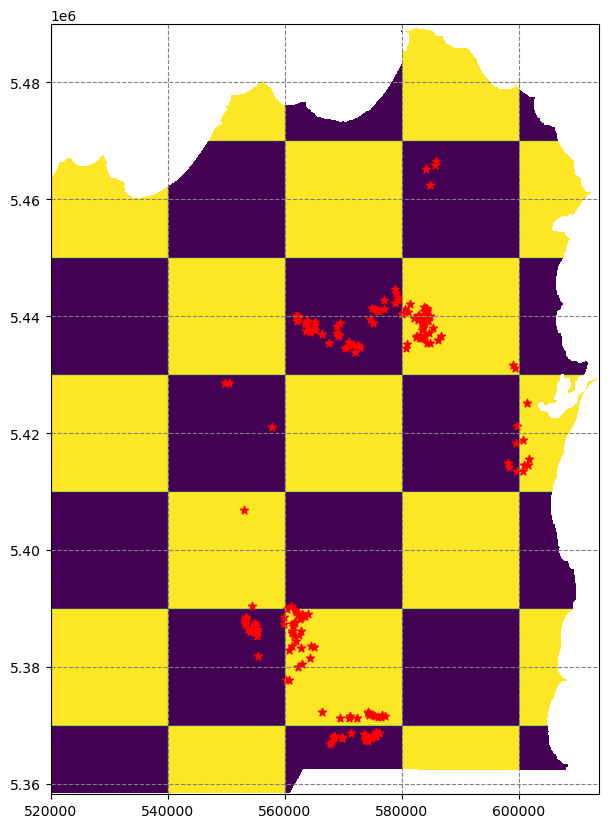

In [29]:
# make checkerboard
checker = make_checkerboard(data[0].shape, (400,400))
checker[nodata_mask] = np.nan

#plot checkerboard
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(checker, extent=region)
df.plot(ax=ax, marker='*', facecolor='r')
plt.show()

In [30]:
# data into checkers
X_check0 = X_pix[checker.flatten()==0]
y_check0 = y_pix[checker.flatten()==0]

X_check1 = X_pix[checker.flatten()==1]
y_check1 = y_pix[checker.flatten()==1]

# remove nans
X_check0 = X_check0[~np.isnan(y_check0)]
y_check0 = y_check0[~np.isnan(y_check0)]

X_check1 = X_check1[~np.isnan(y_check1)]
y_check1 = y_check1[~np.isnan(y_check1)]

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

# run undersampling
X_check0, y_check0 = rus.fit_resample(X_check0, y_check0)
X_check1, y_check1 = rus.fit_resample(X_check1, y_check1)

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

Checker 0: X data array shape is (1949724, 7), y labels array shape is (1949724,)
Checker 1: X data array shape is (2053224, 7), y labels array shape is (2053224,)
Checker 0: X data array shape is (114860, 7), y labels array shape is (114860,)
Checker 1: X data array shape is (106618, 7), y labels array shape is (106618,)


For this project, we will use th checkerboard method from the first notebook. Splitting up the labels would also be valid. 

In [31]:
# fit some models
model0 = XGBClassifier(n_jobs=cpus-1)
model1 = XGBClassifier(n_jobs=cpus-1)

model0.fit(X_check0, y_check0)
model1.fit(X_check1, y_check1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=7,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
# Generate probability maps
pred_ar0 = get_proba_map(X_pix, nodata_mask, model0)
pred_ar1 = get_proba_map(X_pix, nodata_mask, model1)

# Calculate the difference map
difference_map = pred_ar0 - pred_ar1

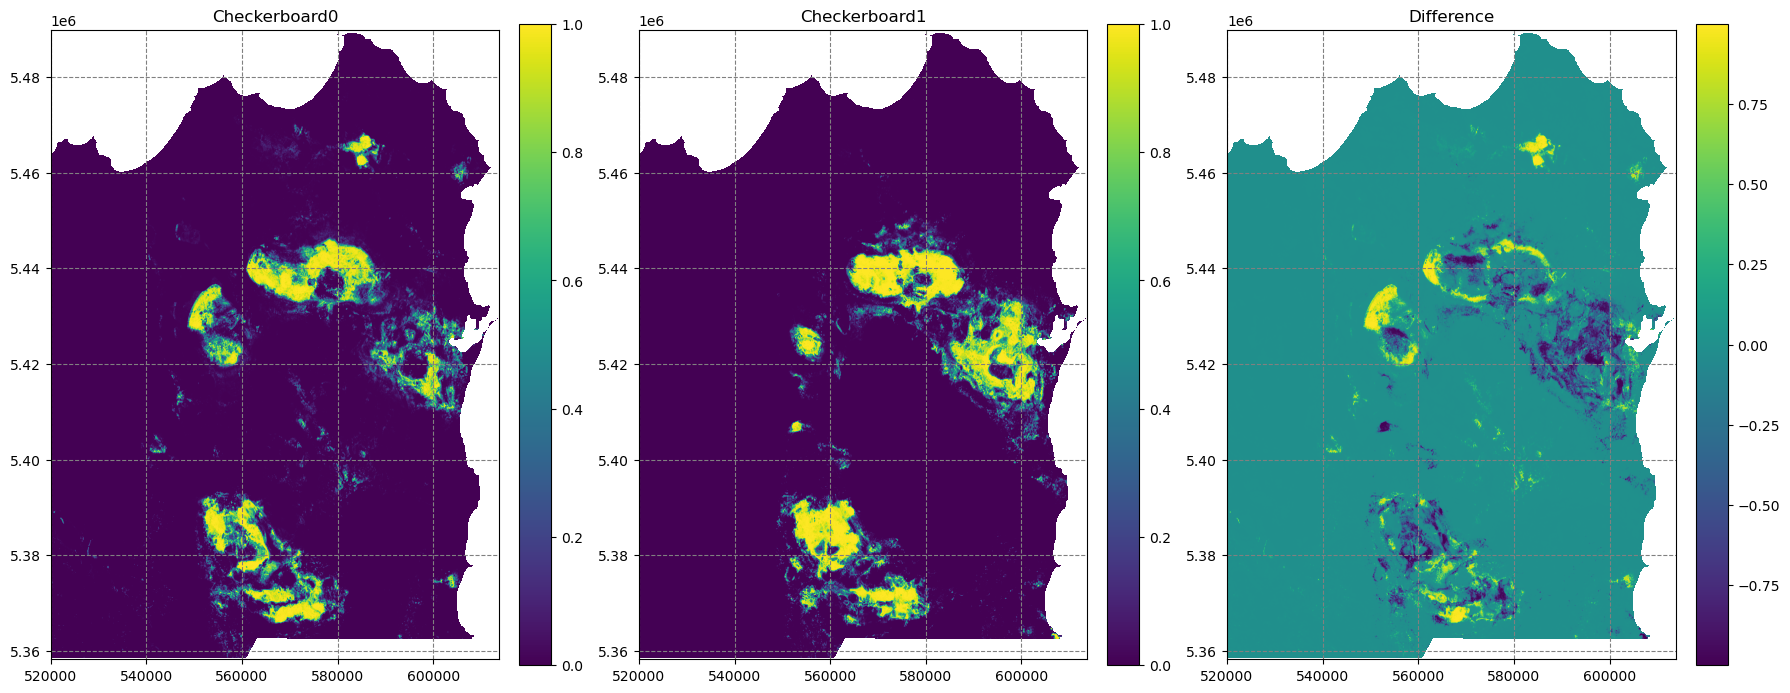

In [33]:
# Plot probability maps
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i, (ar, title) in enumerate(zip([pred_ar0, pred_ar1, difference_map], ['Checkerboard0', 'Checkerboard1', 'Difference'])):
    if title == 'Difference':
        im = ax[i].imshow(ar, extent=region)
    else:
        im = ax[i].imshow(ar, extent=region, vmin=0, vmax=1)
    ax[i].set_title(title)
    # df.plot(ax=ax[i], marker='*', facecolor='w')
    fig.colorbar(im, ax=ax[i], orientation='vertical', fraction=0.064, pad=0.04)

plt.tight_layout()
plt.show()

## Let's do it with the addtional features:

We are going to run though the same exercise, but with the additional features

In [34]:
# data into checkers
X_check0 = X_pix_new[checker.flatten()==0]
y_check0 = y_pix_new[checker.flatten()==0]

X_check1 = X_pix_new[checker.flatten()==1]
y_check1 = y_pix_new[checker.flatten()==1]

# remove nans
X_check0 = X_check0[~np.isnan(y_check0)]
y_check0 = y_check0[~np.isnan(y_check0)]

X_check1 = X_check1[~np.isnan(y_check1)]
y_check1 = y_check1[~np.isnan(y_check1)]

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

# run undersampling
X_check0_new, y_check0_new = rus.fit_resample(X_check0, y_check0)
X_check1_new, y_check1_new = rus.fit_resample(X_check1, y_check1)

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

Checker 0: X data array shape is (1949724, 16), y labels array shape is (1949724,)
Checker 1: X data array shape is (2053224, 16), y labels array shape is (2053224,)
Checker 0: X data array shape is (1949724, 16), y labels array shape is (1949724,)
Checker 1: X data array shape is (2053224, 16), y labels array shape is (2053224,)


In [35]:
# fit some models
model3 = XGBClassifier(n_jobs=cpus-1)
model4 = XGBClassifier(n_jobs=cpus-1)

model3.fit(X_check0_new, y_check0_new)
model4.fit(X_check1_new, y_check1_new)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=7,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
# Generate probability maps
pred_ar3 = get_proba_map(X_pix_new, nodata_mask, model3)
pred_ar4 = get_proba_map(X_pix_new, nodata_mask, model4)

# Calculate the difference map
difference_map2 = pred_ar3 - pred_ar4

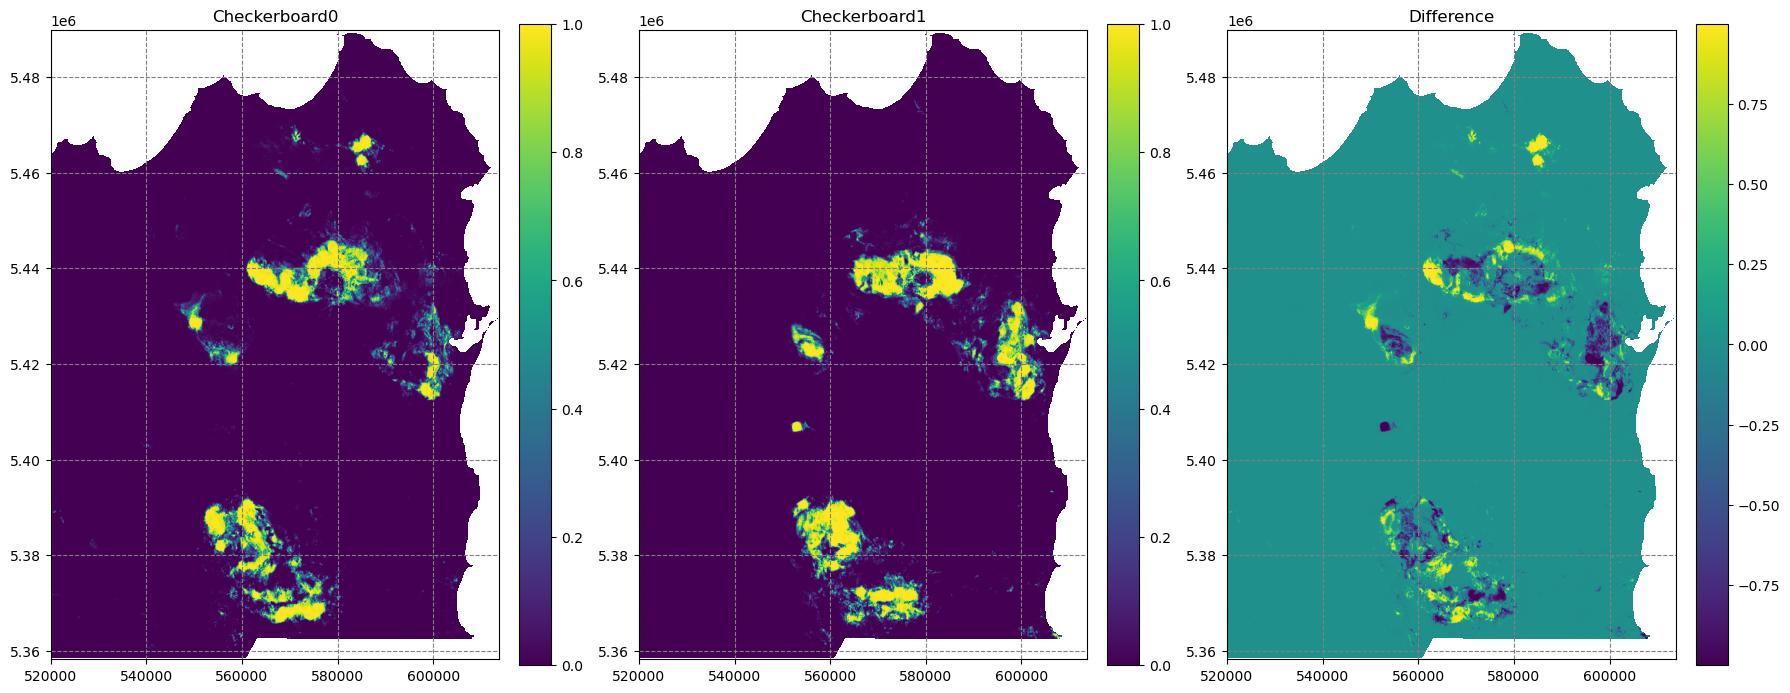

In [37]:
# Plot probability maps
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i, (ar, title) in enumerate(zip([pred_ar3, pred_ar4, difference_map2], ['Checkerboard0', 'Checkerboard1', 'Difference'])):
    if title == 'Difference':
        im = ax[i].imshow(ar, extent=region)
    else:
        im = ax[i].imshow(ar, extent=region, vmin=0, vmax=1)
    ax[i].set_title(title)
    # df.plot(ax=ax[i], marker='*', facecolor='w')
    fig.colorbar(im, ax=ax[i], orientation='vertical', fraction=0.064, pad=0.04)

plt.tight_layout()
plt.show()

Are these maps exactly the same? Below is a plot comparing the checkerboard 1 outputs with a difference map. 

In [38]:
# Calculate the difference map
difference_map3 = pred_ar4 - pred_ar1

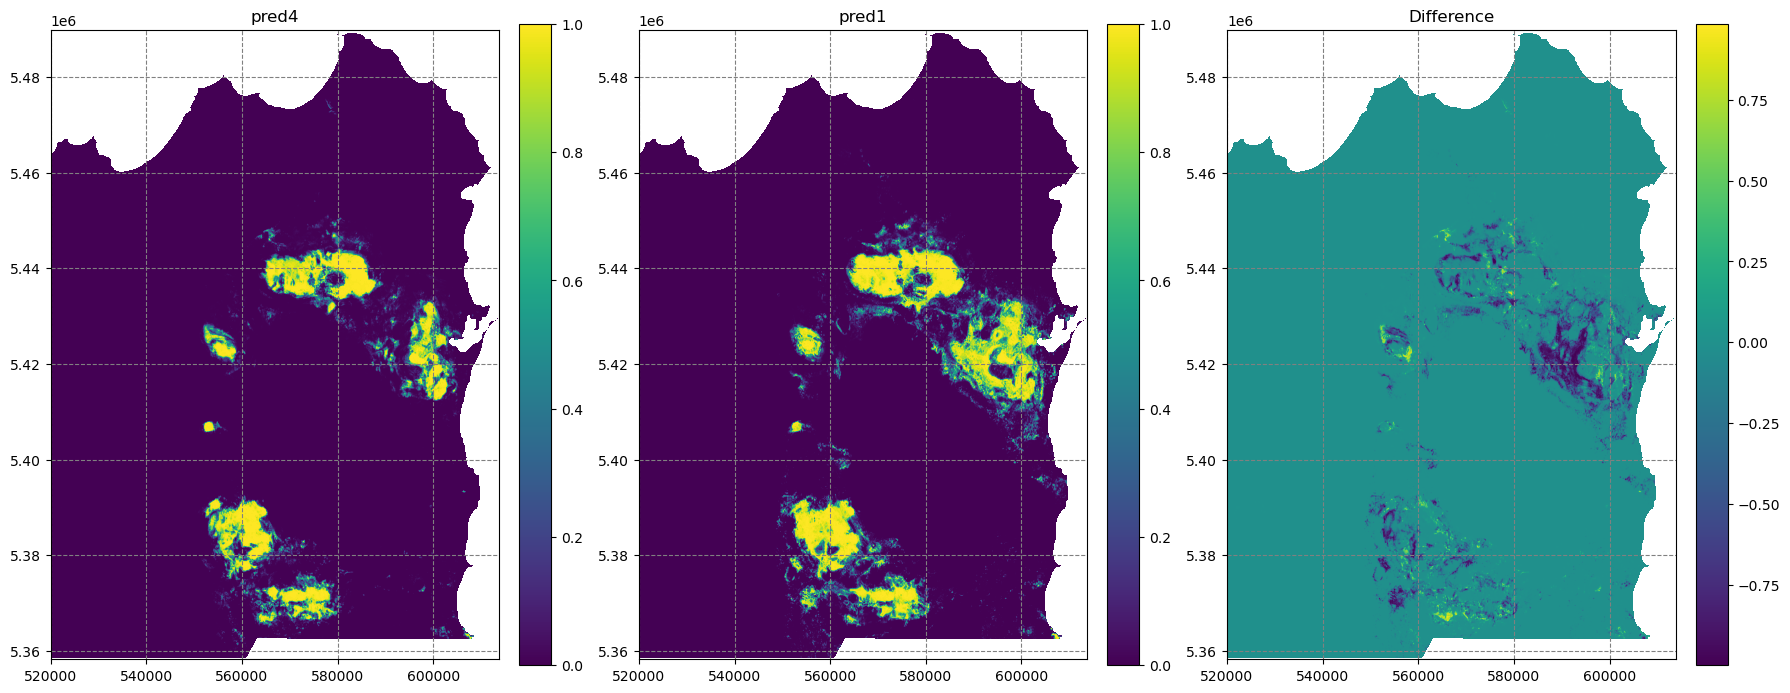

In [39]:
# Plot probability maps
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i, (ar, title) in enumerate(zip([pred_ar4, pred_ar1, difference_map3], ['pred4', 'pred1', 'Difference'])):
    if title == 'Difference':
        im = ax[i].imshow(ar, extent=region)
    else:
        im = ax[i].imshow(ar, extent=region, vmin=0, vmax=1)
    ax[i].set_title(title)
    # df.plot(ax=ax[i], marker='*', facecolor='w')
    fig.colorbar(im, ax=ax[i], orientation='vertical', fraction=0.064, pad=0.04)

plt.tight_layout()
plt.show()

With the additional data, we get a slightly different probability map

### We can merge them all, and normalize them all in one map:

Let's put all of these predictions into one array:

In [40]:
stacked_array = np.stack((pred_ar0, pred_ar1, pred_ar3, pred_ar4), axis=0)

In [41]:
stacked_array.shape

(4, 2633, 1876)

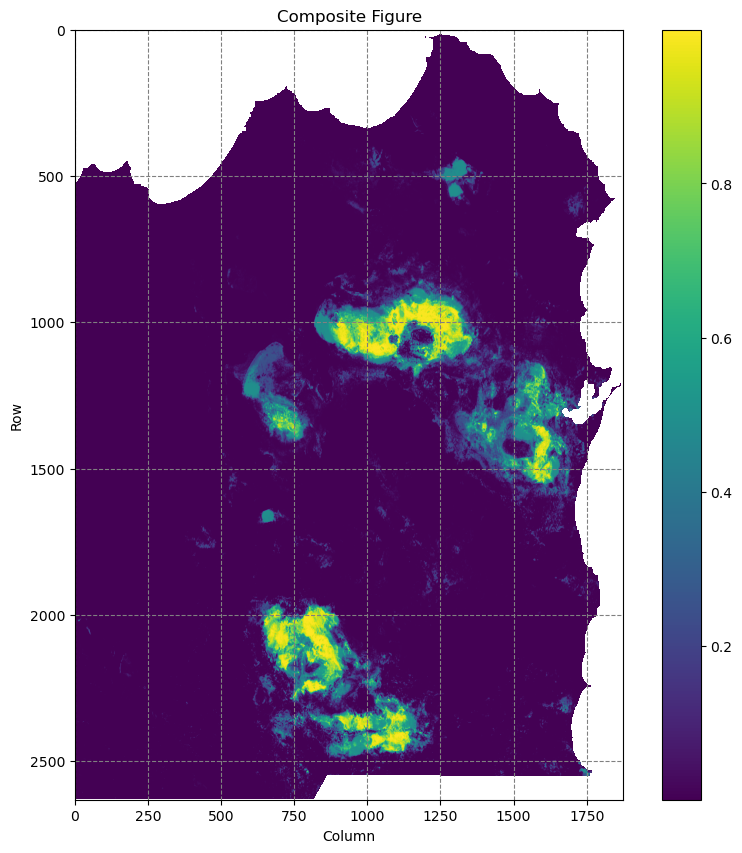

In [42]:
# Sum the array along the first axis (axis=0)
summed_array = np.sum(stacked_array, axis=0) # then we will sum them

# Divide the summed array by 4
resultant_array = summed_array / 4 # 4 layers, divide by 4

# Plot the resultant 2D array
plt.imshow(resultant_array)  # Use 'gray' colormap for grayscale images
plt.colorbar()  # Optional: add a colorbar
plt.title('Composite Figure')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

If we want to further blur the image to be a little to be less dependent on high frequency structure:

In [43]:
from skimage.filters import gaussian

In [44]:
# Apply Gaussian blur
sigma = 5  # Standard deviation for Gaussian kernel, higher the number the bigger the blur
blurred_array = gaussian(resultant_array, sigma=sigma)

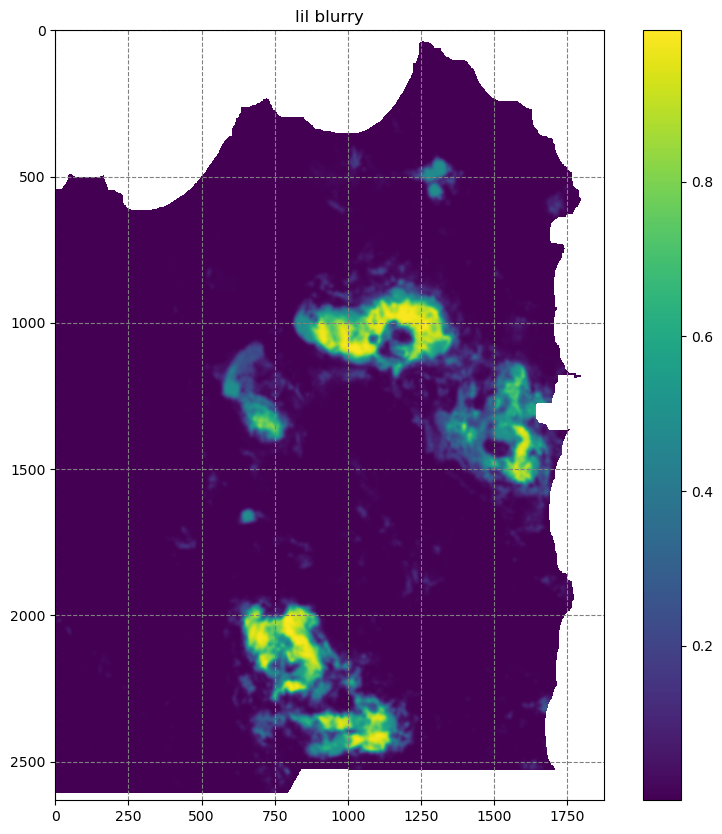

In [45]:
# Plot the resultant 2D array
plt.imshow(blurred_array)  # Use 'gray' colormap for grayscale images
plt.colorbar()  # Optional: add a colorbar
plt.title('lil blurry')
plt.show()

# Final Takeaways

1. Feature Engineering is an important part of ML workflows
2. It does not always dramitcally change the output, in many cases it won't change it at all 
3. Scikit-image can be useful for input feature processing or final output processing for geospatial data. It's a great package!
4. These workflows are dataset and ML model dependant. 